In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns

%pylab inline

matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]

Populating the interactive namespace from numpy and matplotlib


<div class="alert alert-warning">
<h3>Global climate models are inherently noisy given their large physical assumptions about the global climate system. Here, we focus on different ensembles (#1-5) for the same 'historical' time period. We use ensembles, which tweak initial model conditions, to evaluate the range of possible model outcomes within a scenario (<i>i.e.,</i> RCP 8.5).</h3>
<div>

In [2]:
### Initialize arrays
directory = '/home/zlabe/Documents/Projects/NASASTEM_workshop2016/Data/'

years = np.arange(1850,2005+1,1)
months = np.arange(1,13,1)
ens = np.empty((5,len(years)*12,27,288,))

In [3]:
### Read in data (ensembles 1-5, historical)
for i in xrange(5):
    filename = 'tas_grid65N_CCSM4_historical_%s.nc' % (i+1)
    
    data = Dataset(directory + filename)
    ens[i,:,:,:] = data.variables['tas'][:]
    lat = data.variables['lat'][:]
    lon = data.variables['lon'][:]
    data.close()
    
### Reshape [ens,year,month,lat,lon]
ens = np.reshape(ens,(5,len(years),len(months),lat.shape[0],lon.shape[0]))

print ens.shape, '[ensemble,year,month,lat,lon]'

(5, 156, 12, 27, 288) [ensemble,year,month,lat,lon]


In [4]:
### Convert to Celsius
ens = ens - 273.15

<div class="alert alert-warning">
<h3> Let's briefly look at average yearly temperatures for each ensemble.</h3>
</div>

In [5]:
### Import function for calculating yearly averages over grid cells
### See documentation for more details on inputs
from calc_gridMean import calcYearMean

### Read in land area grid
data = Dataset(directory + 'areacella_grid65N_CCSM4.nc')
area = data.variables['areacella'][:]
data.close()

In [6]:
### Calculate averages without weighting area of grid
yrmean = np.apply_over_axes(np.nanmean,ens,(2,3,4))
yrmean = np.squeeze(yrmean)
totalmean = np.apply_over_axes(np.nanmean,ens,(1,2))
totalmean = np.squeeze(totalmean)

### Calculate averaging considering size of grid cell
newtemp = np.empty((5,years.shape[0]))
for i in xrange(yrmean.shape[0]):
    newtemp[i,:] = calcYearMean(ens[i,:,:,:],area)

### Calculate difference in averaging 
differ = newtemp - yrmean

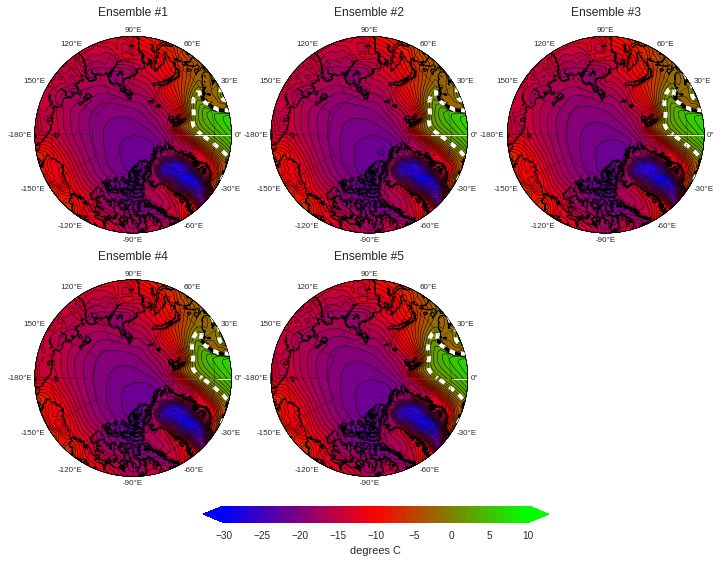

In [7]:
### Plot figure
lons,lats = np.meshgrid(lon,lat)

fig = plt.figure()
for i in xrange(len(totalmean)):
    ax = plt.subplot(2,3,i+1)
    m = Basemap(projection='npstere',boundinglat=66,lon_0=270,resolution='l',round=True)
    m.drawcoastlines()
    parallels = np.arange(50,90,10)
    meridians = np.arange(-180,180,30)
    m.drawparallels(parallels,labels=[False,False,False,False],linewidth=0.5)
    m.drawmeridians(meridians,labels=[True,True,False,False],linewidth=0.5,fontsize=8)
    cs = m.contourf(lons,lats,totalmean[i,:,:],np.arange(-30,11,1),latlon=True,extend='both')
    cs.set_cmap('brg')
    csl1 = m.contour(lons,lats,totalmean[i,:,:],np.arange(-30,11,1),colors='k',linewidths=0.5,latlon=True,linestyles='-')
    csl2 = m.contour(lons,lats,totalmean[i,:,:],np.arange(0,1,1),colors='w',linewidths=4,latlon=True,linestyles='--')
    tl = plt.title('Ensemble #%s' % (i+1))
    tl.set_position([.5, 1.08])

cbar_ax = fig.add_axes([0.32,0.05,0.4,0.03])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',
                        extend='both',extendfrac=0.07)
cbar.set_label('degrees C')
plt.show()

<div class="alert alert-warning">
<h3>Look again, yes, there are differences between the ensembles (albeit very small). The figure above shows the climatological mean considering all months for surface air temperature. The freezing line is highlighted with a white dashed line. Therefore, the averaging reduces the noise between the ensembles. Below  we look more closely at issues that may arise when averaging grid cells.<\h3>
</div>

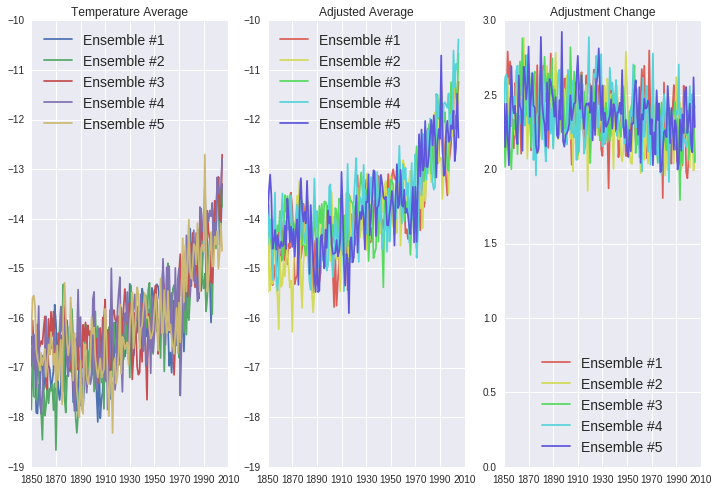

In [8]:
### Plot figure
fig = plt.figure()
ax1 = fig.add_subplot(131)
for i in xrange(yrmean.shape[0]):
    plt.plot(yrmean[i],label='Ensemble #%s' % (i+1))
sns.set_palette("hls")
plt.xticks(np.arange(0,161,20),map(str,np.arange(1850,2025,20)))
plt.legend(loc='upper left',fontsize=14)
plt.ylim([-19,-10])
plt.title('Temperature Average')

ax2 = fig.add_subplot(132)
for i in xrange(yrmean.shape[0]):
    plt.plot(newtemp[i],label='Ensemble #%s' % (i+1))
sns.set_palette("hls")
plt.xticks(np.arange(0,161,20),map(str,np.arange(1850,2025,20)))
plt.legend(loc='upper left',fontsize=14)
plt.ylim([-19,-10])
plt.title('Adjusted Average')

ax3 = fig.add_subplot(133)
for i in xrange(yrmean.shape[0]):
    plt.plot(differ[i],label='Ensemble #%s' % (i+1))
sns.set_palette("hls")
plt.xticks(np.arange(0,161,20),map(str,np.arange(1850,2025,20)))
plt.legend(loc='lower center',fontsize=14)
plt.ylim([0,3])
plt.title('Adjustment Change')

plt.show()

<div class="alert alert-warning">
<h3>We see that by considering the size of the grid cells, temperatures increase... grid cells at lower latitudes (warmer temperatures) are larger and therefore, are weighted more heavily than those close to the poles.</h3>
</div>